In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=a4e07ce0512056d6776a0f987edf3528c5af445b8d3e894f325339e70202def3
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



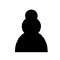
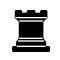
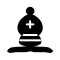
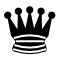
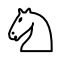
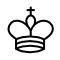
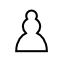
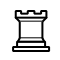
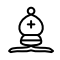
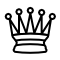
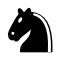
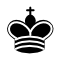

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

https://www.chessprogramming.org/Simplified_Evaluation_Function

In [6]:
%%writefile main.py
# Versión imagory 1.0
import time
import random
from collections import defaultdict
from Chessnut import Game

# Valores de piezas optimizados basados en análisis modernos
piece_values = {
    'P': 100,   # Peón
    'N': 325,   # Caballo 
    'B': 335,   # Alfil
    'R': 500,   # Torre
    'Q': 975,   # Dama
    'K': 20000  # Rey
}

# Tablas de posición optimizadas
piece_square_tables = {
    'P': [
        0,   0,   0,   0,   0,   0,   0,   0,
        50,  50,  50,  50,  50,  50,  50,  50,
        10,  10,  20,  30,  30,  20,  10,  10,
        5,   5,  10,  25,  25,  10,   5,   5,
        0,   0,   0,  20,  20,   0,   0,   0,
        5,  -5, -10,   0,   0, -10,  -5,   5,
        5,  10,  10, -20, -20,  10,  10,   5,
        0,   0,   0,   0,   0,   0,   0,   0
    ],
    'N': [
        -50, -40, -30, -30, -30, -30, -40, -50,
        -40, -20,   0,   5,   5,   0, -20, -40,
        -30,   5,  10,  15,  15,  10,   5, -30,
        -30,   0,  15,  20,  20,  15,   0, -30,
        -30,   5,  15,  20,  20,  15,   5, -30,
        -30,   0,  10,  15,  15,  10,   0, -30,
        -40, -20,   0,   0,   0,   0, -20, -40,
        -50, -40, -30, -30, -30, -30, -40, -50
    ],
    'B': [
        -20, -10, -10, -10, -10, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,  10,  10,   5,   0, -10,
        -10,   5,   5,  10,  10,   5,   5, -10,
        -10,   0,  10,  10,  10,  10,   0, -10,
        -10,  10,  10,  10,  10,  10,  10, -10,
        -10,   5,   0,   0,   0,   0,   5, -10,
        -20, -10, -10, -10, -10, -10, -10, -20
    ],
    'R': [
        0,   0,   0,   5,   5,   0,   0,   0,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        -5,   0,   0,   0,   0,   0,   0,  -5,
        5,   10,  10,  10,  10,  10,  10,   5,
        0,    0,   0,   0,   0,   0,   0,   0
    ],
    'Q': [
        -20, -10, -10,  -5,  -5, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,   5,   5,   5,   0, -10,
        -5,    0,   5,   5,   5,   5,   0,  -5,
        0,     0,   5,   5,   5,   5,   0,  -5,
        -10,   5,   5,   5,   5,   5,   0, -10,
        -10,   0,   5,   0,   0,   0,   0, -10,
        -20, -10, -10,  -5,  -5, -10, -10, -20
    ],
    'K_middlegame': [
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -20, -30, -30, -40, -40, -30, -30, -20,
        -10, -20, -20, -20, -20, -20, -20, -10,
        20,   20,   0,   0,   0,   0,  20,  20,
        20,   30,  10,   0,   0,  10,  30,  20
    ],
    'K_endgame': [
        -50, -40, -30, -20, -20, -30, -40, -50,
        -30, -20, -10,   0,   0, -10, -20, -30,
        -30, -10,  20,  30,  30,  20, -10, -30,
        -30, -10,  30,  40,  40,  30, -10, -30,
        -30, -10,  30,  40,  40,  30, -10, -30,
        -30, -10,  20,  30,  30,  20, -10, -30,
        -30, -30,   0,   0,   0,   0, -30, -30,
        -50, -30, -30, -30, -30, -30, -30, -50
    ]
}

# Tabla de transposición
class TranspositionTable:
    def __init__(self, size=1000000):
        self.size = size
        self.table = {}
    
    def store(self, zobrist_hash, depth, score, move, flag):
        if len(self.table) >= self.size:
            # Política de reemplazo: eliminar entradas más antiguas
            self.table.clear()
        self.table[zobrist_hash] = {
            'depth': depth,
            'score': score,
            'move': move,
            'flag': flag  # 'EXACT', 'LOWER_BOUND', o 'UPPER_BOUND'
        }
    
    def lookup(self, zobrist_hash):
        return self.table.get(zobrist_hash)

# Libro de aperturas simplificado
opening_book = {
    'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -': ['e2e4', 'd2d4'],  # Posición inicial
    'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3': ['e7e5', 'c7c5'],  # Después de 1.e4
    'rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq d3': ['d7d5', 'g8f6'],  # Después de 1.d4
}

def make_move(move, time_to_start_thinking, is_execute_print=True):
    duration = round(time.time() - time_to_start_thinking, 3)
    if is_execute_print:
        print(f'[{move}, {duration}]')
    return move

def evaluate_king_safety(board):
    score = 0
    white_king_square = None
    black_king_square = None
    
    # Encontrar las posiciones de los reyes
    for square in range(64):
        piece = board.get_piece(square)
        if piece == 'K':
            white_king_square = square
        elif piece == 'k':
            black_king_square = square
    
    if white_king_square is not None:
        # Evaluar la protección de peones alrededor del rey blanco
        for offset in [-9, -8, -7, -1, 1, 7, 8, 9]:
            adj_square = white_king_square + offset
            if 0 <= adj_square < 64:
                piece = board.get_piece(adj_square)
                if piece == 'P':
                    score += 10  # Bonus por peón protector
    
    if black_king_square is not None:
        # Evaluar la protección de peones alrededor del rey negro
        for offset in [-9, -8, -7, -1, 1, 7, 8, 9]:
            adj_square = black_king_square + offset
            if 0 <= adj_square < 64:
                piece = board.get_piece(adj_square)
                if piece == 'p':
                    score -= 10  # Bonus por peón protector
    
    return score

def evaluate_mobility(game):
    score = 0
    # Obtener todos los movimientos legales
    all_moves = list(game.get_moves())
    
    # Crear un diccionario para contar movimientos por casilla de origen
    moves_by_square = {}
    for move in all_moves:
        from_square = Game.xy2i(move[0:2])
        moves_by_square[from_square] = moves_by_square.get(from_square, 0) + 1
    
    # Evaluar la movilidad de cada pieza
    for square in range(64):
        piece = game.board.get_piece(square)
        if piece != ' ':
            is_white = piece.isupper()
            # Obtener el número de movimientos para esta pieza
            moves_count = moves_by_square.get(square, 0)
            
            # Diferentes bonus de movilidad según el tipo de pieza
            piece_type = piece.upper()
            mobility_bonus = {
                'P': 2,    # Peón
                'N': 4,    # Caballo
                'B': 5,    # Alfil
                'R': 4,    # Torre
                'Q': 3,    # Dama
                'K': 2     # Rey
            }.get(piece_type, 0)
            
            piece_mobility = moves_count * mobility_bonus
            score += piece_mobility if is_white else -piece_mobility
    
    return score

def evaluate_pawn_structure(board):
    score = 0
    white_pawns = []
    black_pawns = []
    
    # Recopilar posiciones de peones
    for square in range(64):
        piece = board.get_piece(square)
        if piece == 'P':
            white_pawns.append(square)
        elif piece == 'p':
            black_pawns.append(square)
    
    # Evaluar peones doblados y aislados
    for file in range(8):
        white_pawns_in_file = sum(1 for p in white_pawns if p % 8 == file)
        black_pawns_in_file = sum(1 for p in black_pawns if p % 8 == file)
        
        # Penalizar peones doblados
        if white_pawns_in_file > 1:
            score -= 20 * (white_pawns_in_file - 1)
        if black_pawns_in_file > 1:
            score += 20 * (black_pawns_in_file - 1)
        
        # Penalizar peones aislados
        if white_pawns_in_file > 0:
            is_isolated = True
            if file > 0 and any(p % 8 == file - 1 for p in white_pawns):
                is_isolated = False
            if file < 7 and any(p % 8 == file + 1 for p in white_pawns):
                is_isolated = False
            if is_isolated:
                score -= 15
        
        if black_pawns_in_file > 0:
            is_isolated = True
            if file > 0 and any(p % 8 == file - 1 for p in black_pawns):
                is_isolated = False
            if file < 7 and any(p % 8 == file + 1 for p in black_pawns):
                is_isolated = False
            if is_isolated:
                score += 15
    
    return score

def evaluate_position(board, game=None, game_phase='middlegame'):
    # Material y posición básica
    material_score = 0
    position_score = 0
    
    # Evaluar movilidad solo si tenemos acceso al objeto Game
    mobility = 0
    if game is not None:
        mobility = evaluate_mobility(game)
    
    for square in range(64):
        piece = board.get_piece(square)
        if piece != ' ':
            is_white = piece.isupper()
            piece_symbol = piece.upper()
            
            # Puntuación de material
            value = piece_values.get(piece_symbol, 0)
            material_score += value if is_white else -value
            
            # Puntuación posicional
            if piece_symbol in piece_square_tables:
                table = piece_square_tables[piece_symbol]
                if piece_symbol == 'K':
                    table = piece_square_tables['K_endgame'] if game_phase == 'endgame' else piece_square_tables['K_middlegame']
                index = square if is_white else 63 - square
                position_score += table[index] if is_white else -table[index]
    
    # Control del centro
    center_squares = {27, 28, 35, 36}
    center_control = sum(10 if board.get_piece(square).isupper() else 
                        -10 if board.get_piece(square).islower() else 
                        0 for square in center_squares)
    
    # Calcular otros factores
    king_safety = evaluate_king_safety(board)
    pawn_structure = evaluate_pawn_structure(board)
    
    # Pesos según la fase del juego
    weights = {
        'opening': {
            'material': 1.0,
            'position': 1.2,
            'center': 1.5,
            'king_safety': 0.8,
            'mobility': 1.2,
            'pawn_structure': 1.0
        },
        'middlegame': {
            'material': 1.0,
            'position': 1.0,
            'center': 1.0,
            'king_safety': 1.0,
            'mobility': 1.0,
            'pawn_structure': 1.0
        },
        'endgame': {
            'material': 1.2,
            'position': 0.8,
            'center': 0.8,
            'king_safety': 0.6,
            'mobility': 1.5,
            'pawn_structure': 1.2
        }
    }
    
    w = weights[game_phase]
    score = (
        material_score * w['material'] +
        position_score * w['position'] +
        center_control * w['center'] +
        king_safety * w['king_safety'] +
        mobility * w['mobility'] +
        pawn_structure * w['pawn_structure']
    )
    
    return score

def order_moves(moves, game, tt, history):
    move_scores = []
    
    for move in moves:
        score = 0
        
        # 1. Movimiento de la tabla de transposición (prioridad máxima)
        tt_entry = tt.lookup(game.get_fen())
        if tt_entry and tt_entry['move'] == move:
            score += 10000
        
        # 2. Capturas (MVV-LVA)
        capturing_piece = game.board.get_piece(Game.xy2i(move[0:2]))
        captured_piece = game.board.get_piece(Game.xy2i(move[2:4]))
        if captured_piece != ' ':
            # Most Valuable Victim - Least Valuable Attacker
            attacker_value = piece_values[capturing_piece.upper()]
            victim_value = piece_values[captured_piece.upper()]
            score += victim_value - attacker_value/100 + 5000
        
        # 3. Promociones de peones
        if len(move) == 5:  # Movimiento de promoción
            score += piece_values[move[4].upper()] + 4000
        
        # 4. Movimientos que dan jaque
        test_game = Game(game.get_fen())
        test_game.apply_move(move)
        
        # Determinar el color activo basado en FEN
        fen = test_game.get_fen()
        active_color = fen.split()[1]  # El segundo campo del FEN indica el jugador activo
        
        # Encontrar el rey del oponente
        king_square = None
        king_piece = 'k' if active_color == 'w' else 'K'
        
        for sq in range(64):
            piece = test_game.board.get_piece(sq)
            if piece == king_piece:
                king_square = sq
                break
        
        if king_square is not None:
            # Verificar si alguna pieza puede capturar al rey
            is_check = False
            all_moves = list(test_game.get_moves())
            # Convertir los movimientos a pares de origen-destino
            move_pairs = [(Game.xy2i(m[0:2]), Game.xy2i(m[2:4])) for m in all_moves]
            # Verificar si algún movimiento captura al rey
            if any(dest == king_square for _, dest in move_pairs):
                score += 3000
        
        # 5. Historia de movimientos
        score += history[move] / 100
        
        # 6. Movimientos hacia el centro
        to_square = Game.xy2i(move[2:4])
        center_distance = abs(to_square % 8 - 3.5) + abs(to_square // 8 - 3.5)
        score += (7 - center_distance) * 10
        
        move_scores.append((move, score))
    
    # Ordenar por puntuación descendente
    return [move for move, _ in sorted(move_scores, key=lambda x: x[1], reverse=True)]
    
def is_in_check(game):
    fen = game.get_fen()
    active_color = fen.split()[1]
    
    # Encontrar el rey del jugador activo
    king_piece = 'K' if active_color == 'w' else 'k'
    king_square = None
    
    for sq in range(64):
        if game.board.get_piece(sq) == king_piece:
            king_square = sq
            break
    
    if king_square is None:
        return False
    
    # Obtener todos los movimientos legales del oponente
    moves = list(game.get_moves())
    # Verificar si algún movimiento puede capturar al rey
    for move in moves:
        if Game.xy2i(move[2:4]) == king_square:
            return True
    
    return False
def get_piece_moves(game, square):
    all_moves = list(game.get_moves())
    # Filtrar los movimientos que comienzan en la casilla dada
    return [move for move in all_moves if Game.xy2i(move[0:2]) == square]

def quiescence_search(game, alpha, beta, maximizing, time_start, max_time, depth=0):
    if time.time() - time_start > max_time:
        return evaluate_position(game.board, game)
    
    stand_pat = evaluate_position(game.board, game)
    
    if depth >= 4:
        return stand_pat
    
    if maximizing:
        if stand_pat >= beta:
            return beta
        alpha = max(alpha, stand_pat)
    else:
        if stand_pat <= alpha:
            return alpha
        beta = min(beta, stand_pat)
    
    moves = [move for move in game.get_moves() if 
            game.board.get_piece(Game.xy2i(move[2:4])) != ' ' or
            (len(move) == 5 and move[4] in 'QRBN')]
    
    if not moves:
        return stand_pat
    
    for move in moves:
        g = Game(game.get_fen())
        g.apply_move(move)
        score = quiescence_search(g, alpha, beta, not maximizing, 
                                time_start, max_time, depth + 1)
        
        if maximizing:
            alpha = max(alpha, score)
            if alpha >= beta:
                return beta
        else:
            beta = min(beta, score)
            if alpha >= beta:
                return alpha
    
    return alpha if maximizing else beta
def alpha_beta(game, depth, alpha, beta, maximizing, time_start, max_time, tt, history, null_move=True):
    # Comprobar tiempo
    if time.time() - time_start > max_time:
        return None, evaluate_position(game.board, game)
    
    # Búsqueda en la tabla de transposición
    tt_entry = tt.lookup(game.get_fen())
    if tt_entry and tt_entry['depth'] >= depth:
        if tt_entry['flag'] == 'EXACT':
            return tt_entry['move'], tt_entry['score']
        elif tt_entry['flag'] == 'LOWER_BOUND':
            alpha = max(alpha, tt_entry['score'])
        elif tt_entry['flag'] == 'UPPER_BOUND':
            beta = min(beta, tt_entry['score'])
        if alpha >= beta:
            return tt_entry['move'], tt_entry['score']
    
    # Caso base
    if depth == 0:
        score = quiescence_search(game, alpha, beta, maximizing, time_start, max_time)
        return None, score
    
    moves = list(game.get_moves())
    if not moves:
        return None, evaluate_position(game.board, game)
    
    # Ordenar movimientos
    moves = order_moves(moves, game, tt, history)
    
    best_move = None
    best_score = float('-inf') if maximizing else float('inf')
    original_alpha = alpha
    
    for i, move in enumerate(moves):
        g = Game(game.get_fen())
        g.apply_move(move)
        
        # Reducción de movimientos tardíos (LMR)
        if i >= 4 and depth >= 3 and not is_in_check(game):
            reduction = 1 if i >= 6 else 0
        else:
            reduction = 0
        
        # Búsqueda recursiva
        _, score = alpha_beta(g, depth - 1 - reduction, -beta, -alpha, not maximizing,
                            time_start, max_time, tt, history)
        score = -score
        
        if reduction > 0 and score > alpha:
            _, score = alpha_beta(g, depth - 1, -beta, -alpha, not maximizing,
                                time_start, max_time, tt, history)
            score = -score
        
        if maximizing:
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, score)
        else:
            if score < best_score:
                best_score = score
                best_move = move
            beta = min(beta, score)
        
        if beta <= alpha:
            history[move] += depth * depth
            break
    
    # Almacenar en la tabla de transposición
    flag = 'EXACT'
    if best_score <= original_alpha:
        flag = 'UPPER_BOUND'
    elif best_score >= beta:
        flag = 'LOWER_BOUND'
    tt.store(game.get_fen(), depth, best_score, best_move, flag)
    
    return best_move, best_score

def get_opening_book_move(game):
    fen = game.get_fen()
    if fen in opening_book:
        return random.choice(opening_book[fen])
    return None

def determine_game_phase(game):
    total_material = 0
    fen = game.get_fen().split()[0]  # Primer campo del FEN (posición de piezas)
    
    for piece in fen:
        if piece.upper() in piece_values and piece != 'K' and piece != 'k':
            total_material += piece_values[piece.upper()]
    
    if total_material > 6000:
        return 'opening'
    elif total_material < 3000:
        return 'endgame'
    else:
        return 'middlegame'

def calculate_time_limit(obs):
    base_time = 0.095
    
    # Ajustar tiempo según la fase del juego
    game = Game(obs.board)
    phase = determine_game_phase(game)
    if phase == 'opening':
        return base_time * 0.8  # Menos tiempo en aperturas
    elif phase == 'endgame':
        return base_time * 1.2  # Más tiempo en finales
    
    # Ajustar tiempo según la complejidad de la posición
    moves = list(game.get_moves())
    if len(moves) > 30:  # Posición compleja
        return base_time * 1.1
    
    return base_time

def chess_bot(obs):
    time_start = time.time()
    max_time = calculate_time_limit(obs)
    game = Game(obs.board)
    moves = list(game.get_moves())
    is_white = obs.mark == 'white'
    
    # Inicializar estructuras
    tt = TranspositionTable()
    history = defaultdict(int)
    
    # Verificar libro de aperturas
    if obs.step < 10:
        book_move = get_opening_book_move(game)
        if book_move and book_move in moves:
            return make_move(book_move, time_start)
    
    # Verificar mates en uno
    for move in moves:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return make_move(move, time_start)
    
    # Búsqueda iterativa profunda con ventana de aspiración
    best_move = None
    depth = 1
    prev_score = 0
    window = 50
    
    while time.time() - time_start < max_time * 0.8:  # Reservar 20% del tiempo
        try:
            alpha = prev_score - window
            beta = prev_score + window
            
            move, score = alpha_beta(game, depth, alpha, beta, is_white, 
                                   time_start, max_time, tt, history)
            
            if move:
                best_move = move
                prev_score = score
                window = max(10, window // 2)  # Reducir la ventana
            else:
                # La búsqueda falló, ampliar la ventana y reintentar
                window *= 2
                continue
                
        except TimeoutError:
            break
        
        depth += 1
    
    if best_move:
        return make_move(best_move, time_start)
    
    # Movimiento de respaldo
    captures = [move for move in moves if game.board.get_piece(Game.xy2i(move[2:4])) != ' ']
    if captures:
        return make_move(max(captures, key=lambda m: 
            piece_values[game.board.get_piece(Game.xy2i(m[2:4])).upper()]), time_start)
    
    return make_move(random.choice(moves), time_start)

Writing main.py


[f2f3, 0.108]
[g2g3, 0.142]
[c2c3, 0.146]
[c3b4, 0.214]
[b4a5, 0.155]
[g3g4, 0.152]
[d1b3, 0.183]
[f3g4, 0.348]
[b3e6, 0.321]
[e6e7, 0.36]
[g4h5, 0.146]
[a5b6, 0.149]
[b6c7, 0.178]
[c7b8b, 0.256]
[a1a2, 0.264]
[b8d6, 0.215]
[d2d4, 0.256]
[c1f4, 0.271]
[h2h3, 0.331]
[e2f3, 0.334]
[a2a5, 0.211]
[a5f5, 0.237]
[f4e5, 0.22]
[e5g7, 0.169]
[e1d2, 0.132]
[h5g6, 0.274]
[f1e2, 0.172]
[e2b5, 0.165]
[f5d5, 0.123]
[h3h4, 0.119]
[d2e2, 0.123]
[e2f2, 0.116]
[b5e8, 0.116]
[f2g2, 0.11]
[g7f8, 0.104]
[b2b3, 0.224]
[g2f1, 0.213]
[h1h3, 0.184]
[e8a4, 0.196]
[a4e8, 0.178]
[e8a4, 0.204]
[a4e8, 0.179]
Agent exit status/reward/time left: 
	 DONE / 0.5 / 5.892826
	 DONE / 0.5 / 10





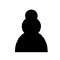
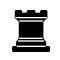
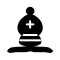
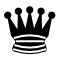
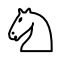
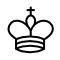
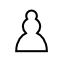
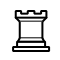
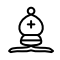
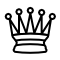
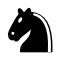
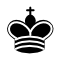

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500) 